In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

In [61]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [9]:
df = pd.read_csv("/Users/souravmohile/Codingwoding/Jupyter/British Airways Review Analysis/ReviewData/ReviewCSV")

In [10]:
df.head(30)

,Title,Review
0,"""angry, disappointed, and unsatisfied""","angry, disappointed, and unsatisfied. my ro..."
1,"""ba now stands for basic airways""","as an infrequent flyer, british airways wa..."
2,"""a totally unremarkable flight""","a totally unremarkable flight, on time, as ..."
3,“ba clearly does not care”,1. ground crew in heathrow left 60 passen...
4,"""reflect a downward trend of the airline""",london heathrow to gibraltar on 24th octob...
5,"""one of my better flights""",first time flying british airways and i wou...
6,"""i would still recommend ba""",i flew london to cairo and return in octobe...
7,"""the worst experience ever""",absolutely the worst experience ever. flew...
8,"""an exceptional crew member""",flew back from malta after scattering our ...
9,"""even ryanair have more space""","cabin luggage had to go to cargo, even when ..."


In [20]:
import nltk

In [24]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/souravmohile/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [43]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/souravmohile/nltk_data...


True

In [56]:
import pprint

In [44]:
from nltk.sentiment import SentimentIntensityAnalyzer 
sia = SentimentIntensityAnalyzer()


In [79]:
results = {}
num = 0
for i in df["Review"]:
    num += 1
    result = sia.polarity_scores(i)
    results[num] = result


In [80]:
results

{1: {'neg': 0.104, 'neu': 0.811, 'pos': 0.085, 'compound': -0.4118},
 2: {'neg': 0.058, 'neu': 0.885, 'pos': 0.057, 'compound': -0.0989},
 3: {'neg': 0.175, 'neu': 0.779, 'pos': 0.046, 'compound': -0.6042},
 4: {'neg': 0.117, 'neu': 0.848, 'pos': 0.035, 'compound': -0.96},
 5: {'neg': 0.067, 'neu': 0.861, 'pos': 0.072, 'compound': 0.3763},
 6: {'neg': 0.0, 'neu': 0.577, 'pos': 0.423, 'compound': 0.9613},
 7: {'neg': 0.073, 'neu': 0.728, 'pos': 0.199, 'compound': 0.9659},
 8: {'neg': 0.215, 'neu': 0.763, 'pos': 0.022, 'compound': -0.9903},
 9: {'neg': 0.041, 'neu': 0.748, 'pos': 0.211, 'compound': 0.9628},
 10: {'neg': 0.047, 'neu': 0.809, 'pos': 0.144, 'compound': 0.6786},
 11: {'neg': 0.039, 'neu': 0.88, 'pos': 0.081, 'compound': 0.5957},
 12: {'neg': 0.133, 'neu': 0.828, 'pos': 0.039, 'compound': -0.9248},
 13: {'neg': 0.024, 'neu': 0.902, 'pos': 0.074, 'compound': 0.8588},
 14: {'neg': 0.096, 'neu': 0.878, 'pos': 0.026, 'compound': -0.7717},
 15: {'neg': 0.145, 'neu': 0.855, 'pos': 

In [89]:
sentiments = pd.DataFrame(results).T
sentiments

,neg,neu,pos,compound
1,0.104,0.811,0.085,-0.4118
2,0.058,0.885,0.057,-0.0989
3,0.175,0.779,0.046,-0.6042
4,0.117,0.848,0.035,-0.9600
5,0.067,0.861,0.072,0.3763
...,...,...,...,...
3608,0.025,0.873,0.102,0.9129
3609,0.000,0.712,0.288,0.8720
3610,0.056,0.875,0.069,0.4516
3611,0.000,0.711,0.289,0.9148


<AxesSubplot:ylabel='compound'>

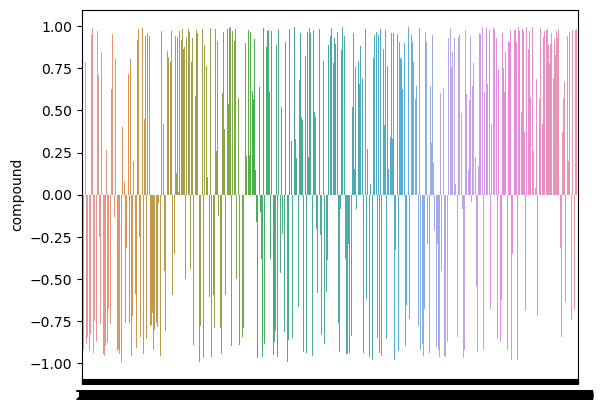

In [93]:
sns.barplot(x=df.index, y='compound', data=sentiments)

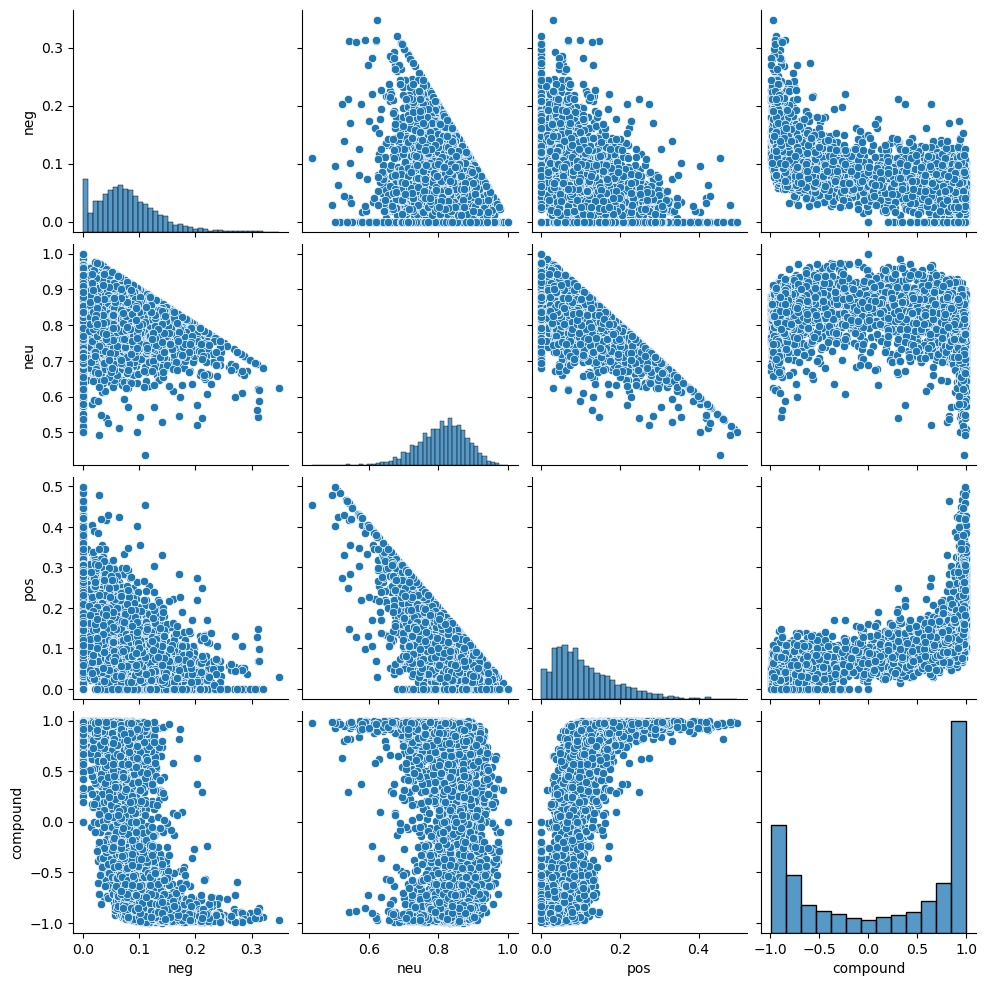

In [95]:
sns.pairplot(data=sentiments, vars=["neg","neu","pos","compound"])

<AxesSubplot:>

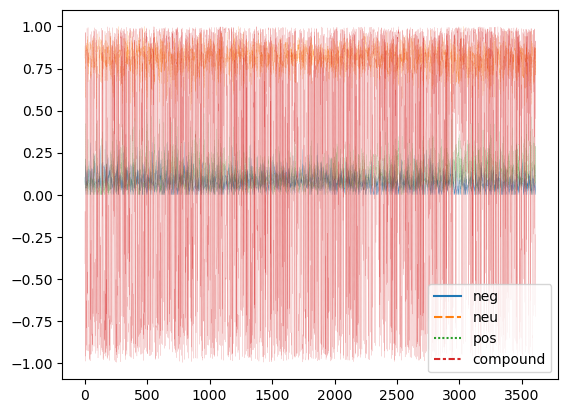

In [100]:
sns.lineplot(data=sentiments, linewidth=0.1)

<AxesSubplot:xlabel='compound', ylabel='compound'>

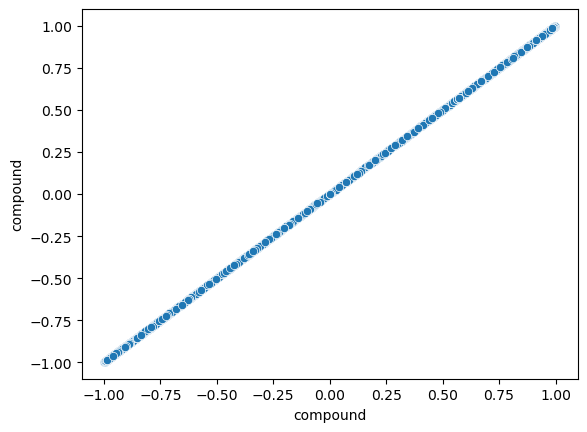

In [108]:
sns.scatterplot(x="compound", y="compound", data=sentiments)

<AxesSubplot:>

Text(0.5, 0, 'X-axis')

Text(0, 0.5, 'Y-axis')

Text(0.5, 1.0, '4 Quadrant Scatter Plot')

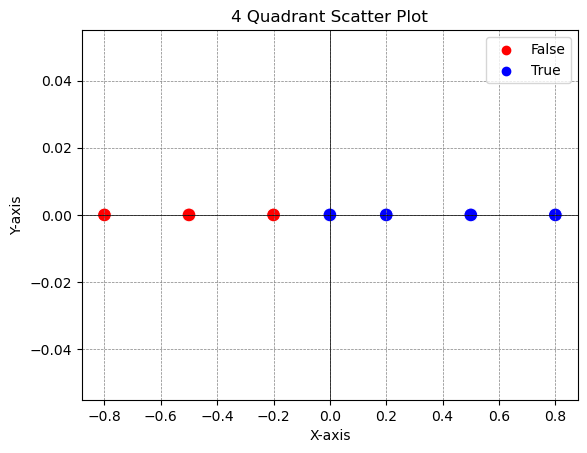

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data from -1 to 1
data = [-0.8, -0.5, -0.2, 0, 0.2, 0.5, 0.8]

# Create a Seaborn scatter plot
sns.scatterplot(x=data, y=[0]*len(data), hue=[x >= 0 for x in data], palette={True: 'blue', False: 'red'}, s=100)

# Customize the plot
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Set axis labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Set plot title
plt.title('4 Quadrant Scatter Plot')

# Show the plot
plt.show()

In [110]:
sentiments["compound"]

1      -0.4118
2      -0.0989
3      -0.6042
4      -0.9600
5       0.3763
         ...  
3608    0.9129
3609    0.8720
3610    0.4516
3611    0.9148
3612    0.8096
Name: compound, Length: 3612, dtype: float64

In [112]:
positive = 0
negative = 0
for i in sentiments["compound"]:
    if i > 0:
        positive += 1
    else:
        negative += 1
    
positive
negative
        

2094

1518

In [113]:
2094 + 1518

3612

In [119]:
very_satisfied = 0
satisfied = 0
neutral_good = 0
neutral_bad = 0
unsatisfied = 0
very_unsatisfied = 0

for i in sentiments["compound"]:
    if i >= 0.75:
        very_satisfied += 1
    elif i >= 0.5 and i < 0.75:
        satisfied += 1
    elif i >= 0 and i < 0.5:
        neutral_good += 1
    elif i >= -0.5 and i < 0:
        neutral_bad += 1
    elif i >= -0.75 and i < -0.5:
        unsatisfied += 1
    elif i < -0.75:
        very_unsatisfied += 1
    
    
very_satisfied 
satisfied 
neutral_good 
neutral_bad 
unsatisfied
very_unsatisfied 

1470

293

341

330

310

868

In [121]:
1470+293+341+330+310+868

3612

In [122]:
(1470/3612)*100

40.69767441860465

In [123]:
(293/3612)*100

8.111849390919158

In [124]:
(341/3612)*100

9.44075304540421

In [125]:
(330/3612)*100

9.136212624584719

In [126]:
(310/3612)*100

8.58250276854928

In [127]:
(868/3612)*100

24.031007751937985